# Sample notebook

This notebook represents a sample model development process with many critical flaws and typical shortcommings.

It was created for instructional purposed on how NOT to do things. Please DO NOT use for any real modeling!

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

## Data loading

In [3]:
# Uncomment on Michael's copmuter
# df = pd.read_csv("/home/michael/data.csv")
# Download from http://some.link/that/does/not/work/anymore.csv
df = pd.read_csv("data/housing.csv")

In [4]:
df

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,location,near_ocean
0,"336,351.99",39.57,1804.0,383.0,381.0,4.45,33.78 N 111.4 W,Yes
1,"533,034.41",36.17,2655.0,391.0,368.0,8.68,31.36 N 117.16 W,No
2,"59,438.25",50.65,15.0,4.0,3.0,0.89,38.21 N 118.85 W,No
3,"162,643.46",21.32,3418.0,606.0,569.0,4.55,31.43 N 112.63 W,Yes
4,"280,015.39",10.93,9792.0,1759.0,2000.0,4.39,30.88 N 108.15 W,No
...,...,...,...,...,...,...,...,...
95,"412,804.48",19.57,2129.0,371.0,406.0,10.29,36.15 N 116.51 W,Yes
96,"151,976.85",34.52,1143.0,228.0,246.0,3.26,37.15 N 102.21 W,Yes
97,"259,237.12",44.09,2921.0,613.0,611.0,3.56,40.13 N 125.18 W,Yes
98,"125,401.82",12.69,1888.0,381.0,348.0,4.23,36.6 N 125.3 W,No


In [5]:
# change some columns to numeric
df.median_house_value = df.median_house_value.replace({',': ''}, regex=True).apply(pd.to_numeric, 1)
df.median_house_value = df.median_house_value.astype(float)

In [6]:
df["housing_median_age"] = pd.to_numeric(df["housing_median_age"], errors="coerce")

In [7]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,location,near_ocean
0,336351.99,39.57,1804.0,383.0,381.0,4.45,33.78 N 111.4 W,Yes
1,533034.41,36.17,2655.0,391.0,368.0,8.68,31.36 N 117.16 W,No
2,59438.25,50.65,15.0,4.0,3.0,0.89,38.21 N 118.85 W,No
3,162643.46,21.32,3418.0,606.0,569.0,4.55,31.43 N 112.63 W,Yes
4,280015.39,10.93,9792.0,1759.0,2000.0,4.39,30.88 N 108.15 W,No


### Parse the "location" column into "latitude" and "longitude"

"34.56 N 123.45 W" -> 34.56, -123.45 

In [8]:
df = df.join(
    df["location"].str.extract("([1-9][0-9]{0,2}\.[0-9]{2}) [NS] ([1-9][0-9]{0,2}\.[0-9]{2}) W").rename(
        columns={0: "latitude", 1: "longitude"}).astype(float)
)
df["longitude"] *= -1

In [9]:
df.drop(columns=["location"], inplace=True)

In [10]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
0,336351.99,39.57,1804.0,383.0,381.0,4.45,Yes,NaN,NaN
1,533034.41,36.17,2655.0,391.0,368.0,8.68,No,31.36,-117.16
2,59438.25,50.65,15.0,4.0,3.0,0.89,No,38.21,-118.85
3,162643.46,21.32,3418.0,606.0,569.0,4.55,Yes,31.43,-112.63
4,280015.39,10.93,9792.0,1759.0,2000.0,4.39,No,30.88,-108.15


### Convert "near_ocean" to `bool`

In [11]:
df["near_ocean"] = df["near_ocean"].apply(lambda near_ocean: 1 if near_ocean == "Yes" else 0)

## Data review

In [12]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
0,336351.99,39.57,1804.0,383.0,381.0,4.45,1,NaN,NaN
1,533034.41,36.17,2655.0,391.0,368.0,8.68,0,31.36,-117.16
2,59438.25,50.65,15.0,4.0,3.0,0.89,0,38.21,-118.85
3,162643.46,21.32,3418.0,606.0,569.0,4.55,1,31.43,-112.63
4,280015.39,10.93,9792.0,1759.0,2000.0,4.39,0,30.88,-108.15


In [13]:
df.describe()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
count,100.000000,92.000000,100.000000,100.000000,100.000000,100.000000,100.000000,79.000000,79.000000
mean,212169.320700,28.732065,2540.030000,507.080000,477.640000,3.716200,0.530000,35.080253,-119.234937
std,125622.095769,12.266397,2077.111643,361.450185,344.892796,1.860173,0.501614,3.929425,10.992996
min,50758.460000,3.430000,15.000000,4.000000,3.000000,0.780000,0.000000,26.390000,-145.270000
25%,114505.597500,19.450000,1546.750000,308.500000,292.500000,2.695000,0.000000,32.625000,-126.670000
50%,179879.840000,30.380000,1995.000000,427.500000,374.000000,3.470000,1.000000,34.780000,-118.050000
75%,281718.847500,36.772500,3021.750000,628.000000,593.500000,4.375000,1.000000,37.680000,-112.595000
max,587083.300000,57.640000,13434.000000,2048.000000,2000.000000,10.290000,1.000000,47.150000,-97.380000


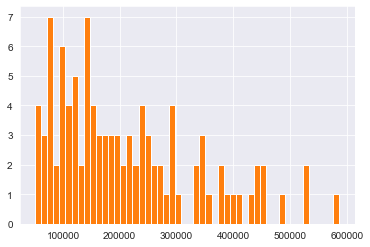

In [14]:
plt.hist(df["median_house_value"], bins=50, color="C1")
plt.show()

## Data preparation

In [15]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_household"] = df["total_bedrooms"] / df["households"]

In [16]:
df["const"] = 1

In [17]:
df.dropna(inplace=True)

## Train a linear model

In [18]:
target_var = "median_house_value"
features = list(df.columns)
features.remove(target_var)

In [19]:
model = sm.GLM(df[target_var], df[features]).fit()

## Evaluate model

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     median_house_value   No. Observations:                   72
Model:                            GLM   Df Residuals:                       61
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                      9.4026e+09
Method:                          IRLS   Log-Likelihood:                -922.91
Date:                Tue, 05 Nov 2019   Deviance:                   5.7356e+11
Time:                        00:16:53   Pearson chi2:                 5.74e+11
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
housing_median_age        14.5743   1035.934      0.014      0.989   -2015.818    2044.967
total_rooms               19.9588     28.481      0.701      0.483     -35.863      75.780
total_bedrooms          -179.7729    171.109     -1.051      0.293    -515.140     155.594
households                71.7717    180.706      0.397      0.691    -282.406     425.950
median_income           4.447e+04   7976.135      5.575      0.000    2.88e+04    6.01e+04
near_ocean              7.043e+04   2.55e+04      2.766      0.006    2.05e+04     1.2e+05
latitude                 673.0798   3007.061      0.224      0.823   -5220.652    6566.812
longitude                 -5.2859   1099.064     -0.005      0.996   -2159.412    2148.841
rooms_per_household    -2.669e+04   1.93e+04     -1.380      0.168   -6.46e+04    1.12e+04
bedrooms_per_household  1.394e+05   1.18e+05      1.178      0.239   -9.25e+04    3.71e+05
const                  -1.623e+04   2.23e+05     -0.073      0.942   -4.52e+05     4.2e+05
==========================================================================================
"""

### Calculate Root Mean Square Error

In [21]:
import math

In [22]:
def rmse(x, y):
    N = len(x)
    errors = 0
    
    for i in range(N):
        errors += (x[i] - y[i]) ** 2
    
    return math.sqrt(errors / N)

In [23]:
rmse(model.predict(), df[target_var].values)

89252.72763516215

### Calculate Model Lift

Lift is an additional model statistic that measures the discrimination power.

To calculate it, we first sort the data according to the target variable (actual median house value) in a descending order and calculate *lift* for each observation (row) as

> lift  = 2 &times; (cm_pct_actual - cm_pct_weight) / total_weight

where
* cm_pct_actual is the cummulative percentage of total house value up to the given observation
* cm_pct_weight is the cummulative percentage of total observation weights

For simplicity, we give each observation in the dataset an equal weight of 1

In [24]:
def calc_lift(values, weights):
    cm_value = 0
    cm_value_pct = 0
    cm_weight = 0
    cm_weight_pct = 0
    
    lift = 0
    
    for value,weight in zip(values, weights):
        cm_value += value
        cm_value_pct = cm_value / values.sum()
        cm_weight += weight
        cm_weight_pct = cm_weight / weights.sum()
        
        lift += 2 * (cm_value_pct - cm_weight_pct) / weights.sum()
        
    return lift

In [25]:
calc_lift(df.sort_values(target_var, ascending=False)[target_var], np.ones(len(df)))

0.32422559553219715

Then we calculate lift when sorted by the predicted value

In [26]:
df["predictions"] = model.predict()

In [27]:
calc_lift(df.sort_values("predictions", ascending=False)[target_var], np.ones(len(df)))

0.22910131012911644